In [ ]:
import json
import re
import os
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from typing import List, Dict, Tuple

import numpy as np
import pandas as pd

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

import torch
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
from sklearn.model_selection import train_test_split


# connect google drive for persistent data storage
path_data = "drive/MyDrive/Colab Notebooks/academic_details/"

# Data preparation

In [ ]:
# Default output for invalid or 'nan' cases
DEFAULT_OUTPUT = {"High School": "No", "Apprenticeship": "No", "Bachelor": "No", "Master": "No", "PhD": "No"}


def load_json_data(file_path: str) -> List[Dict[str, str]]:
    """Load the dataset from a JSON file."""
    with open(file_path, "r") as file:
        data = json.load(file)
    return data


def sanitize_output(output_str: str) -> Dict[str, str]:
    """Sanitize and convert the output string into a dictionary, handling special cases."""
    if output_str == "nan" or not output_str:
        return DEFAULT_OUTPUT

    # Normalize 'Yes (preferred)' and 'Preferred' to 'Yes'
    output_str = output_str.replace("Yes (preferred)", "Yes").replace("Preferred", "Yes")

    return eval(output_str)


def preprocess_records(json_data: List[Dict[str, str]]) -> Tuple[List[str], List[Dict[str, str]]]:
    """Preprocess data into input texts and expected outputs, handling 'nan' and invalid cases."""
    input_texts = []
    output_dicts = []

    for record in json_data:
        input_texts.append(record["input"])
        processed_output = sanitize_output(record["output"])
        output_dicts.append(processed_output)

    return input_texts, output_dicts


def convert_to_pandas(inputs: List[str], outputs: List[Dict[str, str]]) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """Convert lists of inputs and outputs into pandas DataFrames."""
    input_df = pd.DataFrame(inputs, columns=["text"])
    output_df = pd.DataFrame(outputs)

    # Convert categorical 'Yes'/'No' into binary 1/0
    output_df.replace({"No": 0, "Yes": 1}, inplace=True)

    return input_df, output_df


def generate_summary_statistics(output_df: pd.DataFrame) -> pd.DataFrame:
    """Generate summary statistics for the output DataFrame."""
    stats = {
        "Total": output_df.count(),
        "Yes Count": output_df.sum(),
        "No Count": output_df.count() - output_df.sum(),
        "Percentage Yes": output_df.mean() * 100,
    }
    return pd.DataFrame(stats)


# Main execution flow
if __name__ == "__main__":
    json_data = load_json_data(os.path.join(path_data, "academic_details.json"))
    input_texts, output_dicts = preprocess_records(json_data)
    x, y = convert_to_pandas(input_texts, output_dicts)
    summary_stats = generate_summary_statistics(y)
    print(summary_stats)

                Total  Yes Count  No Count  Percentage Yes
High School       808         23       785        2.846535
Apprenticeship    808          0       808        0.000000
Bachelor          808        568       240       70.297030
Master            808        360       448       44.554455
PhD               808        181       627       22.400990


# Regex Model

                Accuracy  Precision    Recall  F1 Score   ROC AUC
High School     0.997525   1.000000  0.913043  0.954545  0.956522
Apprenticeship  1.000000   0.000000  0.000000  0.000000       NaN
Bachelor        0.879950   1.000000  0.829225  0.906641  0.914613
Master          0.985149   0.986034  0.980556  0.983287  0.984697
PhD             0.993812   0.994382  0.977901  0.986072  0.988153


<Figure size 800x400 with 0 Axes>

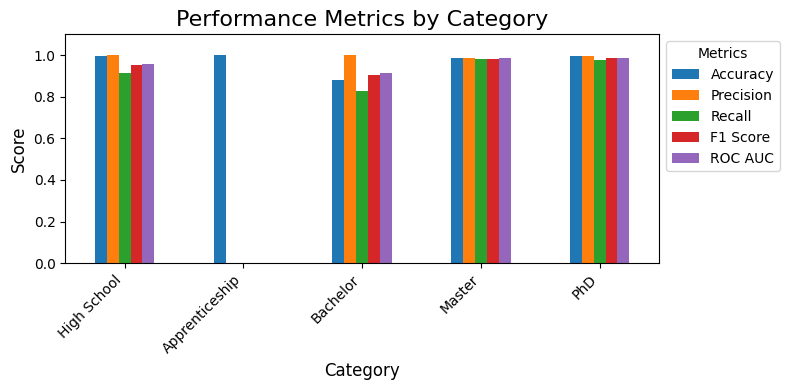

In [ ]:
# Regex patterns for different degrees
degree_patterns: Dict[str, str] = {
    "High School": r"\b(?:high\s+school|secondary\s+school|GED)\b",
    "Apprenticeship": r"\b(?:apprenticeship)\b",
    "Bachelor": r"\b(?:bachelor(?:'s)?|B\.?S\.?|B\.?A\.?)\b",
    "Master": r"\b(?:Masters?|Master[’']s|M\.?S\.?|M\.?S\.?c\.?|M\.?A\.?|graduate|advanced\s+degree|MBA)\b",
    "PhD": r"\b(?:Ph\.?D\.?|PhD|Doctorate|doctoral\s+degree)\b",
}

# Default output structure for missing data
DEFAULT_OUTPUT = {"High School": "No", "Apprenticeship": "No", "Bachelor": "No", "Master": "No", "PhD": "No"}


# Rule-based model using regex
def rule_based_model(text: str) -> Dict[str, str]:
    """Extract academic requirements from the job description using regex rules."""
    result = DEFAULT_OUTPUT.copy()  # Start with default 'No' values
    for degree, pattern in degree_patterns.items():
        if re.search(pattern, text, re.IGNORECASE):
            result[degree] = "Yes"
    return result


# Batch processing wrapper for rule_based_model
def batch_process_model(x: pd.DataFrame) -> pd.DataFrame:
    """Process a batch of texts and apply the rule-based model."""
    df = pd.DataFrame([rule_based_model(text) for text in x["text"].tolist()])
    df.replace({"No": 0, "Yes": 1}, inplace=True)
    return df


# Evaluate the model
def evaluate_model(y_true: pd.DataFrame, y_pred: pd.DataFrame) -> Dict[str, Dict[str, float]]:
    """Evaluate the performance of the model for each degree using various metrics."""
    metrics = {}

    # Iterate through each degree (each column in the DataFrame)
    for degree in y_true.columns:
        true_labels = y_true[degree]
        pred_labels = y_pred[degree]

        roc_auc = None
        if len(true_labels.unique()) != 1:
            roc_auc = roc_auc_score(true_labels, pred_labels)

        metrics[degree] = {
            "Accuracy": accuracy_score(true_labels, pred_labels),
            "Precision": precision_score(true_labels, pred_labels, pos_label=1, average="binary", zero_division=0),
            "Recall": recall_score(true_labels, pred_labels, pos_label=1, average="binary", zero_division=0),
            "F1 Score": f1_score(true_labels, pred_labels, pos_label=1, average="binary", zero_division=0),
            "ROC AUC": roc_auc,
        }

    return pd.DataFrame(metrics).T


def plot_metrics(df):
    """
    Plots a grouped bar chart for performance metrics from a given DataFrame.

    Parameters:
    df (pd.DataFrame): A DataFrame where each column represents a performance metric
                       and each row corresponds to a different category (e.g., education level).
    """
    # Check if DataFrame is not empty
    if df.empty:
        raise ValueError("The input DataFrame is empty.")

    # Plot settings
    plt.figure(figsize=(8, 4))
    df.plot(kind="bar", figsize=(8, 4))

    # Customizations
    plt.title("Performance Metrics by Category", fontsize=16)
    plt.xlabel("Category", fontsize=12)
    plt.ylabel("Score", fontsize=12)
    plt.ylim(0, 1.1)
    plt.xticks(rotation=45, ha="right")
    plt.legend(loc="upper left", bbox_to_anchor=(1, 1), title="Metrics")
    plt.tight_layout()

    # Show plot
    plt.show()


# Example usage (you would replace these with actual data):
if __name__ == "__main__":
    # Get model predictions
    y_pred = batch_process_model(x)

    # Evaluate the model
    metrics = evaluate_model(y, y_pred)
    print(metrics)

    plot_metrics(metrics)

In [ ]:
print(x)

                                                  text
0    - Bachelor's degree or Master's degree in Comp...
1    - Graduate degree in biostatistics or related ...
2    - Currently has, or is in the process of obtai...
3             - MS in Machine Learning (PhD preferred)
4    - A Degree in Computer Science, Engineering, M...
..                                                 ...
803  - Bachelor's degree or Master's degree in Comp...
804  - Qualified candidates will have completed col...
805  - Bachelor's in a quantitative discipline or s...
806  - PhD from a quantitative area such as STEM (S...
807  - Bachelor's or Master's degree in Computer Sc...

[808 rows x 1 columns]


In [ ]:
print(y)

     High School  Apprenticeship  Bachelor  Master  PhD
0              0               0         1       1    0
1              0               0         0       1    0
2              0               0         1       0    0
3              0               0         0       1    1
4              0               0         1       0    0
..           ...             ...       ...     ...  ...
803            0               0         1       1    0
804            1               0         0       0    0
805            0               0         1       0    0
806            0               0         0       0    1
807            0               0         1       1    1

[808 rows x 5 columns]


# Data Preparation for fine tuning

In [ ]:
train_texts, test_texts, train_labels, test_labels = train_test_split(
    x["text"].tolist(), y.values, test_size=0.2, random_state=42
)


x_train = pd.DataFrame(train_texts, columns=["text"])
x_test = pd.DataFrame(test_texts, columns=["text"])
y_train = pd.DataFrame(train_labels, columns=y.columns)
y_test = pd.DataFrame(test_labels, columns=y.columns)


# Create a custom dataset class
class MultiLabelDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels[idx], dtype=torch.float)
        return item

    def __len__(self):
        return len(self.labels)

# Fine Tune BERT

In [ ]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Using device: {device}")


# Load pre-trained tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

# Tokenize the texts
train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=512)
test_encodings = tokenizer(test_texts, truncation=True, padding=True, max_length=512)

# Prepare datasets
train_dataset = MultiLabelDataset(train_encodings, train_labels)
test_dataset = MultiLabelDataset(test_encodings, test_labels)

# Load pre-trained BERT model with a classification head (for multi-label classification)
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=5)

# Define training arguments
training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    warmup_ratio=0.2,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=10,
    evaluation_strategy="epoch",
)

# Define Trainer
trainer = Trainer(model=model, args=training_args, train_dataset=train_dataset, eval_dataset=test_dataset)

# Train the model
trainer.train()

# Evaluate the model
trainer.evaluate()

# Save the fine-tuned model and tokenizer
model.save_pretrained(os.path.join(path_data, "bert_fine_tuned_model"))
tokenizer.save_pretrained(os.path.join(path_data, "bert_fine_tuned_model"))

Using device: cuda


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,0.251700,0.163774
2,0.106900,0.079887
3,0.056800,0.051243


('drive/MyDrive/Colab Notebooks/academic_details/bert_fine_tuned_model/tokenizer_config.json',
 'drive/MyDrive/Colab Notebooks/academic_details/bert_fine_tuned_model/special_tokens_map.json',
 'drive/MyDrive/Colab Notebooks/academic_details/bert_fine_tuned_model/vocab.txt',
 'drive/MyDrive/Colab Notebooks/academic_details/bert_fine_tuned_model/added_tokens.json')

BERT Model Performance:
                Accuracy  Precision   Recall  F1 Score   ROC AUC
High School     1.000000   1.000000  1.00000  1.000000  1.000000
Apprenticeship  1.000000   0.000000  0.00000  0.000000       NaN
Bachelor        0.993827   1.000000  0.99115  0.995556  0.995575
Master          0.993827   0.984127  1.00000  0.992000  0.995000
PhD             0.993827   0.971429  1.00000  0.985507  0.996094
Regex Model Performance:
                Accuracy  Precision    Recall  F1 Score   ROC AUC
High School     0.993827        1.0  0.857143  0.923077  0.928571
Apprenticeship  1.000000        0.0  0.000000  0.000000       NaN
Bachelor        0.895062        1.0  0.849558  0.918660  0.924779
Master          1.000000        1.0  1.000000  1.000000  1.000000
PhD             1.000000        1.0  1.000000  1.000000  1.000000


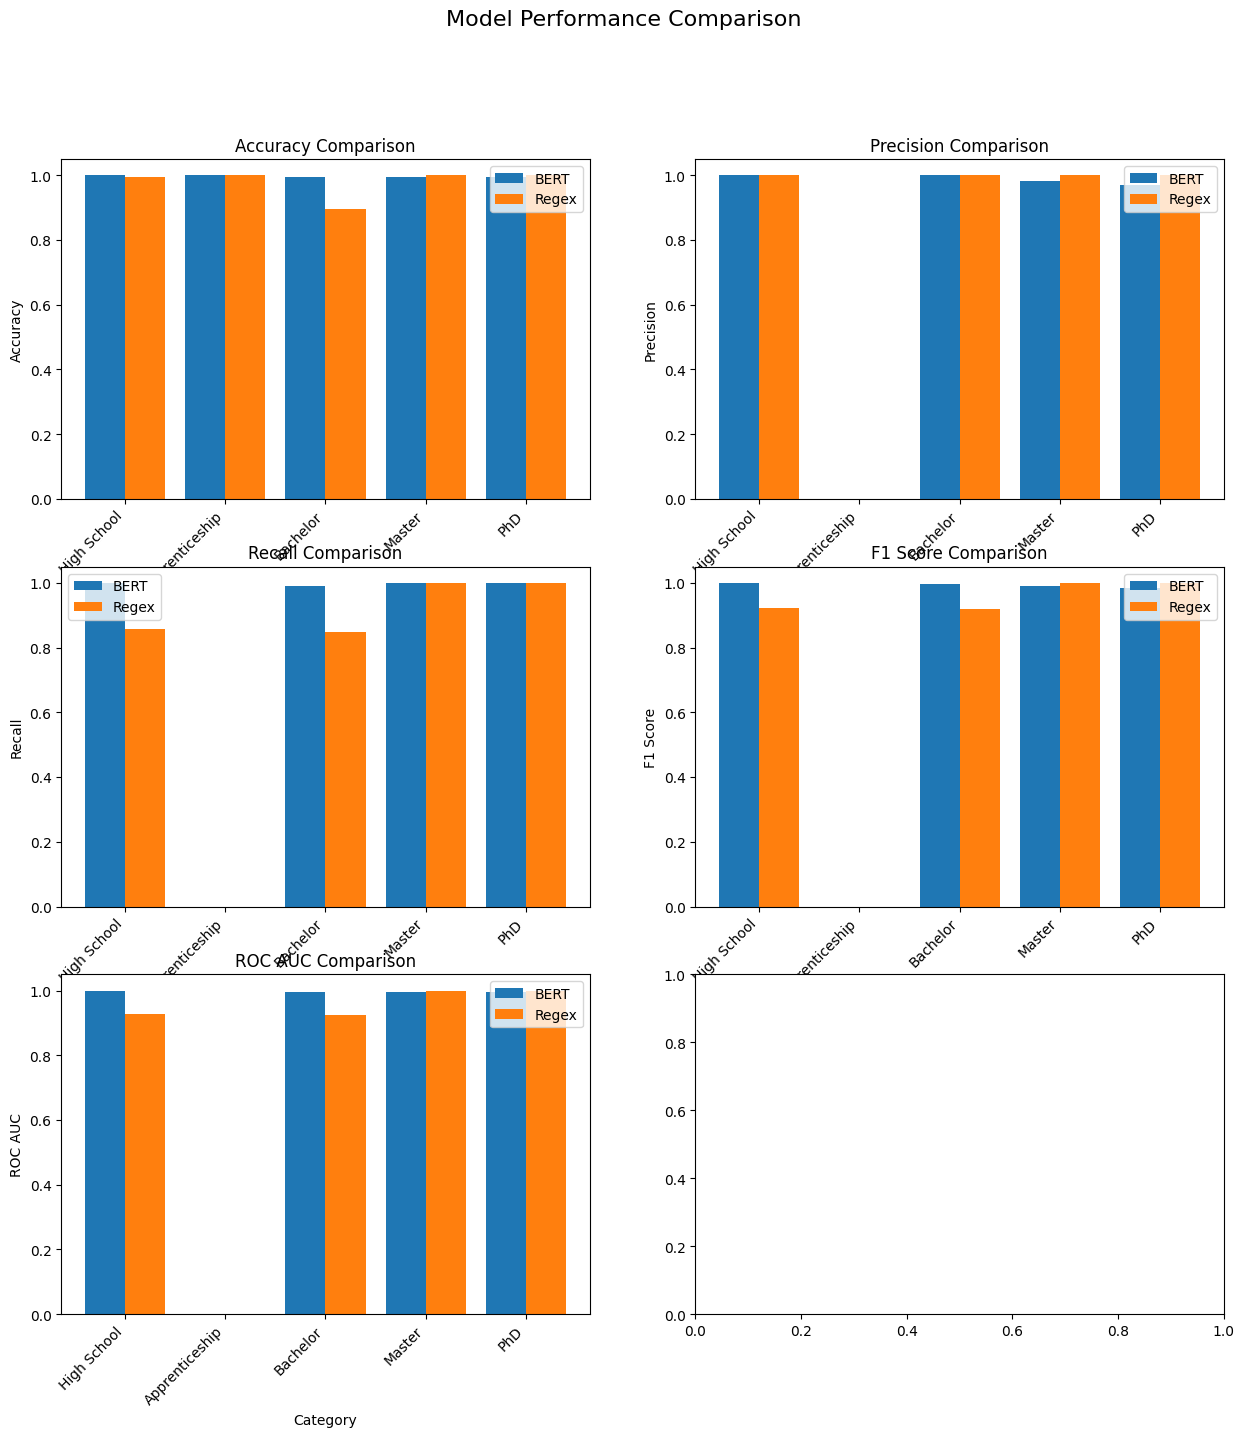

In [ ]:
import torch
import pandas as pd
from transformers import BertTokenizer, BertForSequenceClassification

# Load your fine-tuned BERT model
model_path = os.path.join(path_data, "bert_fine_tuned_model")  # Path to your saved fine-tuned model
tokenizer = BertTokenizer.from_pretrained(model_path)
model = BertForSequenceClassification.from_pretrained(model_path)

# Move the model to GPU if available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)


# Function to get BERT model predictions
def get_bert_predictions(x: pd.DataFrame) -> pd.DataFrame:
    """Predict labels using the fine-tuned BERT model."""
    model.eval()  # Set the model to evaluation mode

    texts = x["text"].tolist()
    encodings = tokenizer(texts, truncation=True, padding=True, max_length=512, return_tensors="pt")
    encodings = {key: tensor.to(device) for key, tensor in encodings.items()}

    # Inference
    with torch.no_grad():
        outputs = model(**encodings)
        logits = outputs.logits
        predictions = torch.sigmoid(logits).cpu().numpy()  # Convert logits to probabilities

    # Convert probabilities to binary values (threshold 0.5)
    predictions = (predictions > 0.5).astype(int)

    # Convert to a DataFrame
    columns = ["High School", "Apprenticeship", "Bachelor", "Master", "PhD"]
    pred_df = pd.DataFrame(predictions, columns=columns)

    return pred_df


def plot_comparison(*dataframes, model_names):
    if len(dataframes) != len(model_names):
        raise ValueError("Number of dataframes must match number of model names")

    metrics = dataframes[0].columns
    categories = dataframes[0].index

    num_metrics = len(metrics)
    num_rows = (num_metrics + 1) // 2  # Ensure we have enough rows for all metrics

    fig, axs = plt.subplots(num_rows, 2, figsize=(15, 5 * num_rows))
    fig.suptitle("Model Performance Comparison", fontsize=16)

    for i, metric in enumerate(metrics):
        ax = axs[i // 2, i % 2] if num_metrics > 1 else axs

        x = np.arange(len(categories))
        width = 0.8 / len(dataframes)

        for j, df in enumerate(dataframes):
            offset = (j - (len(dataframes) - 1) / 2) * width
            ax.bar(x + offset, df[metric], width, label=model_names[j])

        ax.set_xlabel("Category")
        ax.set_ylabel(metric)
        ax.set_title(f"{metric} Comparison")
        ax.set_xticks(x)
        ax.set_xticklabels(categories, rotation=45, ha="right")
        ax.legend()


y_pred_bert = get_bert_predictions(x_test)
y_pred_regex = batch_process_model(x_test)

# Evaluate both models using the same function
metrics_bert = evaluate_model(y_test, y_pred_bert)
metrics_regex = evaluate_model(y_test, y_pred_regex)

print("BERT Model Performance:")
print(metrics_bert)

print("Regex Model Performance:")
print(metrics_regex)

plot_comparison(metrics_bert, metrics_regex, model_names=["BERT", "Regex"])

BERT Model Performance:
                Accuracy  Precision    Recall  F1 Score   ROC AUC
High School     0.998762   1.000000  0.956522  0.977778  0.978261
Apprenticeship  1.000000   0.000000  0.000000  0.000000       NaN
Bachelor        0.995050   1.000000  0.992958  0.996466  0.996479
Master          0.996287   0.994460  0.997222  0.995839  0.996379
PhD             0.998762   0.994505  1.000000  0.997245  0.999203
Regex Model Performance:
                Accuracy  Precision    Recall  F1 Score   ROC AUC
High School     0.997525   1.000000  0.913043  0.954545  0.956522
Apprenticeship  1.000000   0.000000  0.000000  0.000000       NaN
Bachelor        0.879950   1.000000  0.829225  0.906641  0.914613
Master          0.985149   0.986034  0.980556  0.983287  0.984697
PhD             0.993812   0.994382  0.977901  0.986072  0.988153


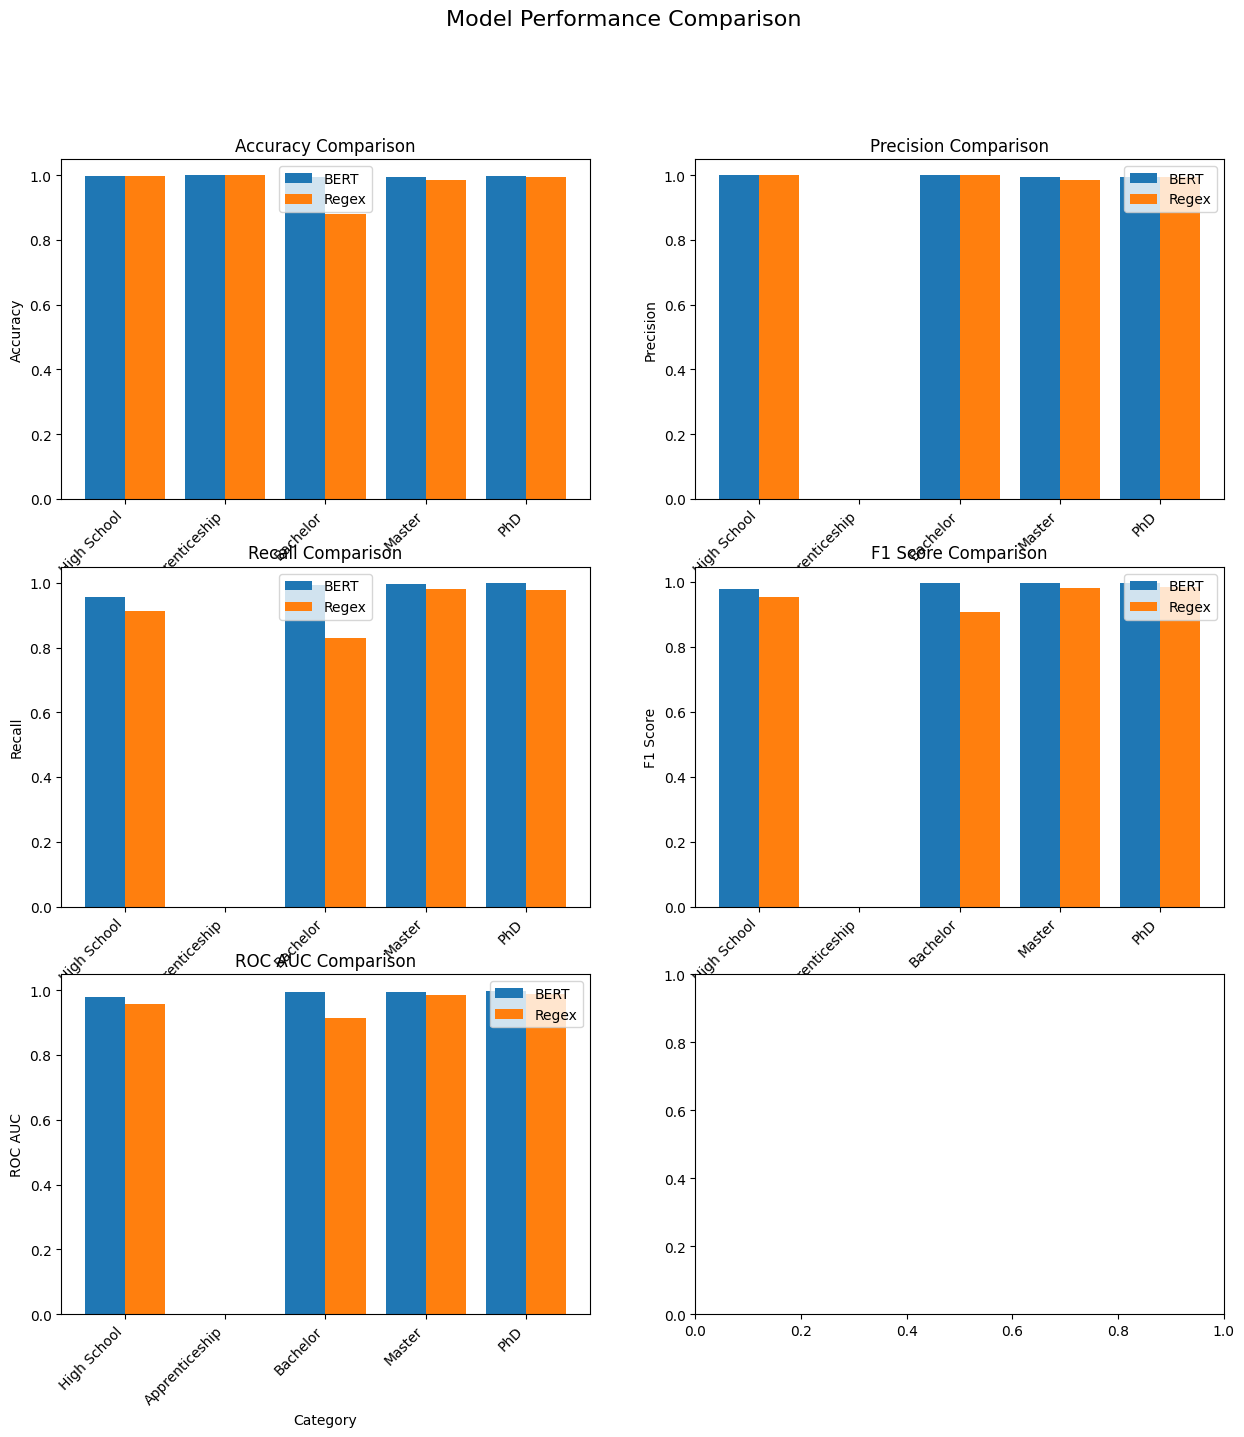

In [ ]:
# Evaluate on a whole data set

y_pred_bert = get_bert_predictions(x)
y_pred_regex = batch_process_model(x)

# Evaluate both models using the same function
metrics_bert = evaluate_model(y, y_pred_bert)
metrics_regex = evaluate_model(y, y_pred_regex)

print("BERT Model Performance:")
print(metrics_bert)

print("Regex Model Performance:")
print(metrics_regex)

plot_comparison(metrics_bert, metrics_regex, model_names=["BERT", "Regex"])

# Fine Tune Distil Bert

In [ ]:
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, Trainer, TrainingArguments

# Set device to GPU if available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Using device: {device}")

# Load pre-trained tokenizer and model
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")
model = DistilBertForSequenceClassification.from_pretrained(
    "distilbert-base-uncased", num_labels=5
)  # Adjust num_labels according to your dataset

# Tokenize the texts
train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=512)
test_encodings = tokenizer(test_texts, truncation=True, padding=True, max_length=512)

# Prepare datasets
train_dataset = MultiLabelDataset(train_encodings, train_labels)
test_dataset = MultiLabelDataset(test_encodings, test_labels)

# Define training arguments
training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    warmup_ratio=0.2,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=10,
    evaluation_strategy="epoch",
)

# Define Trainer
trainer = Trainer(model=model, args=training_args, train_dataset=train_dataset, eval_dataset=test_dataset)

# Train the model
trainer.train()

# Evaluate the model
trainer.evaluate()

# Save the fine-tuned model and tokenizer
model.save_pretrained(os.path.join(path_data, "distilbert_fine_tuned_model"))
tokenizer.save_pretrained(os.path.join(path_data, "distilbert_fine_tuned_model"))

Using device: cuda


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,0.263100,0.218161
2,0.116000,0.080898
3,0.070100,0.064694


('drive/MyDrive/Colab Notebooks/academic_details/distilbert_fine_tuned_model/tokenizer_config.json',
 'drive/MyDrive/Colab Notebooks/academic_details/distilbert_fine_tuned_model/special_tokens_map.json',
 'drive/MyDrive/Colab Notebooks/academic_details/distilbert_fine_tuned_model/vocab.txt',
 'drive/MyDrive/Colab Notebooks/academic_details/distilbert_fine_tuned_model/added_tokens.json')

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


BERT Model Performance:
                Accuracy  Precision   Recall  F1 Score   ROC AUC
High School     1.000000   1.000000  1.00000  1.000000  1.000000
Apprenticeship  1.000000   0.000000  0.00000  0.000000       NaN
Bachelor        0.993827   1.000000  0.99115  0.995556  0.995575
Master          0.993827   0.984127  1.00000  0.992000  0.995000
PhD             0.993827   0.971429  1.00000  0.985507  0.996094
DistilBERT Model Performance:
                Accuracy  Precision    Recall  F1 Score   ROC AUC
High School     0.987654   1.000000  0.714286  0.833333  0.857143
Apprenticeship  1.000000   0.000000  0.000000  0.000000       NaN
Bachelor        0.975309   0.982301  0.982301  0.982301  0.970742
Master          0.975309   0.953125  0.983871  0.968254  0.976935
PhD             1.000000   1.000000  1.000000  1.000000  1.000000
Regex Model Performance:
                Accuracy  Precision    Recall  F1 Score   ROC AUC
High School     0.993827        1.0  0.857143  0.923077  0.928571
App

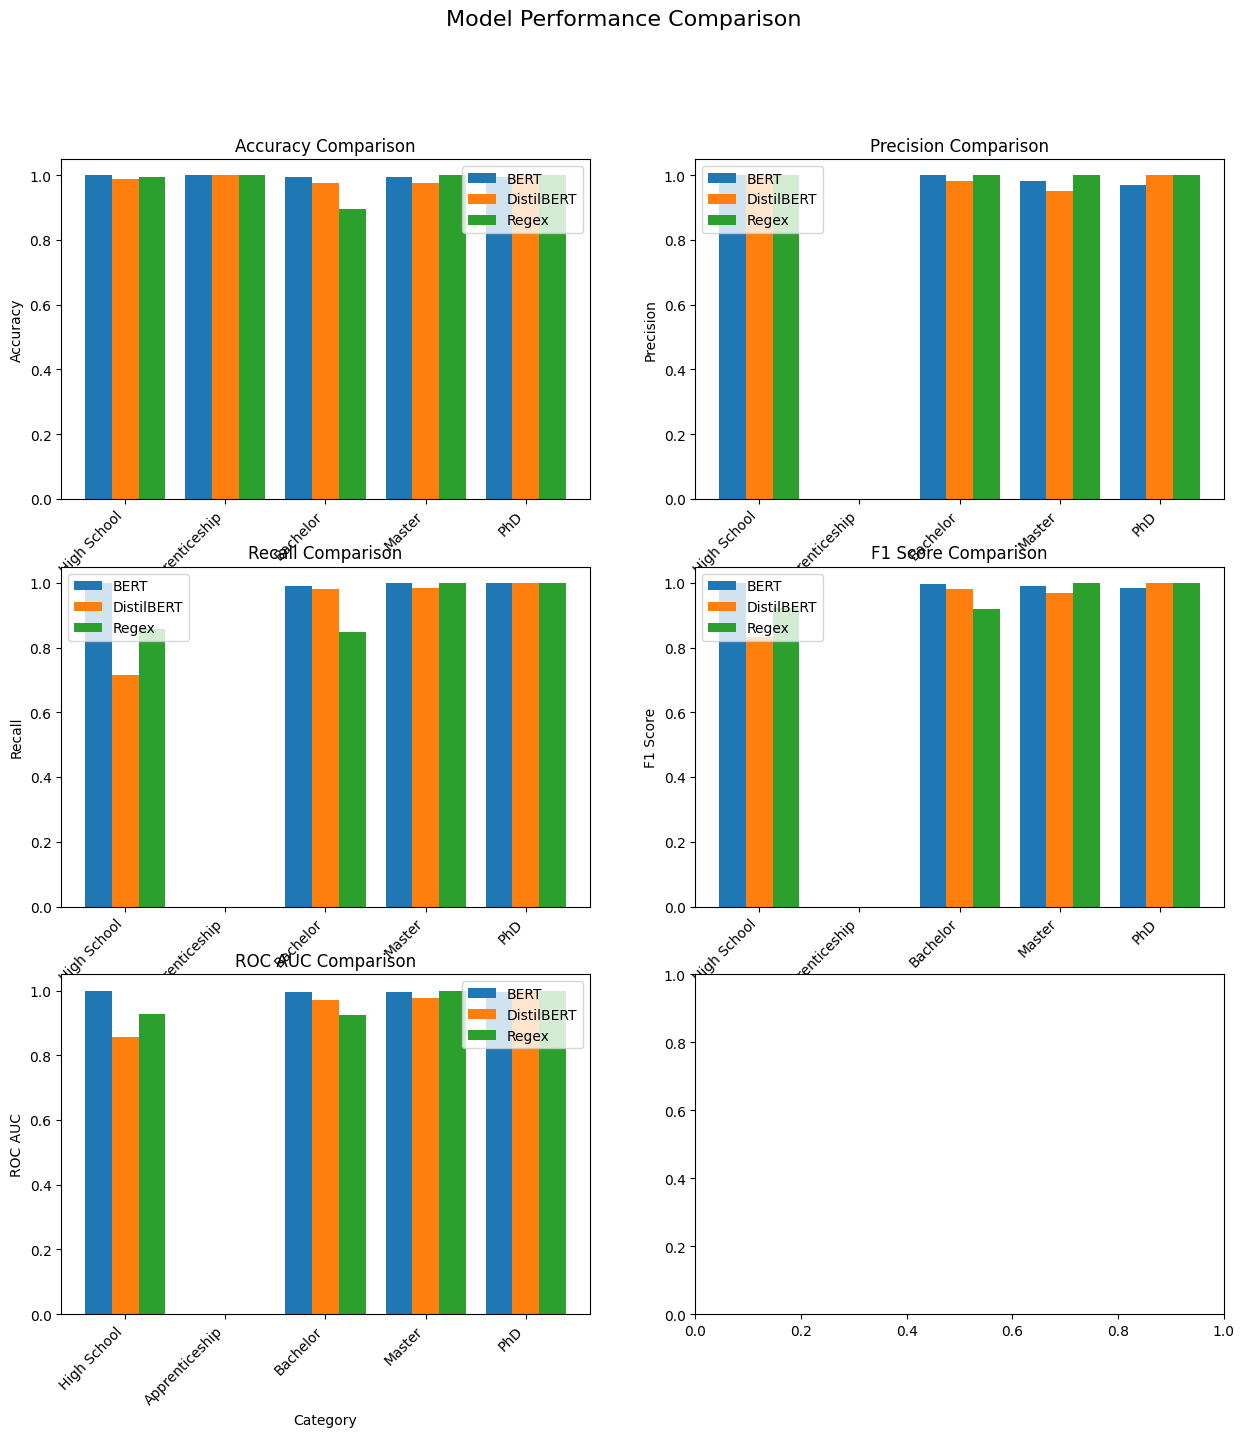

In [ ]:
import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification


def get_transformer_predictions(
    x: pd.DataFrame, model_name: str, model_path: str, device: str = "cuda"
) -> pd.DataFrame:
    # Load the model and tokenizer
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForSequenceClassification.from_pretrained(model_path)
    model.to(device)
    model.eval()  # Set the model to evaluation mode

    texts = x["text"].tolist()
    encodings = tokenizer(texts, truncation=True, padding=True, max_length=512, return_tensors="pt")
    encodings = {key: tensor.to(device) for key, tensor in encodings.items()}

    # Inference
    with torch.no_grad():
        outputs = model(**encodings)
        logits = outputs.logits
        predictions = torch.sigmoid(logits).cpu().numpy()  # Convert logits to probabilities

    # Convert probabilities to binary values (threshold 0.5)
    predictions = (predictions > 0.5).astype(int)

    # Convert to a DataFrame
    columns = ["High School", "Apprenticeship", "Bachelor", "Master", "PhD"]
    pred_df = pd.DataFrame(predictions, columns=columns)

    return pred_df


y_pred_bert = get_transformer_predictions(
    x=x_test, model_name="bert-base-uncased", model_path=os.path.join(path_data, "bert_fine_tuned_model"), device="cuda"
)

y_pred_distilbert = get_transformer_predictions(
    x=x_test,
    model_name="distilbert-base-uncased",
    model_path=os.path.join(path_data, "distilbert_fine_tuned_model"),
    device="cuda",
)

y_pred_regex = batch_process_model(x_test)

# Evaluate both models using the same function
metrics_bert = evaluate_model(y_test, y_pred_bert)
metrics_distilbert = evaluate_model(y_test, y_pred_distilbert)
metrics_regex = evaluate_model(y_test, y_pred_regex)

print("BERT Model Performance:")
print(metrics_bert)

print("DistilBERT Model Performance:")
print(metrics_distilbert)

print("Regex Model Performance:")
print(metrics_regex)

plot_comparison(metrics_bert, metrics_distilbert, metrics_regex, model_names=["BERT", "DistilBERT", "Regex"])

# NLI Cross encoder



Processing texts: 100%|██████████| 162/162 [00:10<00:00, 14.88it/s]


NLI Model Performance:
                Accuracy  Precision    Recall  F1 Score   ROC AUC
High School     0.962963   1.000000  0.142857  0.250000  0.571429
Apprenticeship  1.000000   0.000000  0.000000  0.000000       NaN
Bachelor        0.419753   0.952381  0.176991  0.298507  0.578291
Master          0.641975   0.833333  0.080645  0.147059  0.535323
PhD             0.802469   1.000000  0.058824  0.111111  0.529412


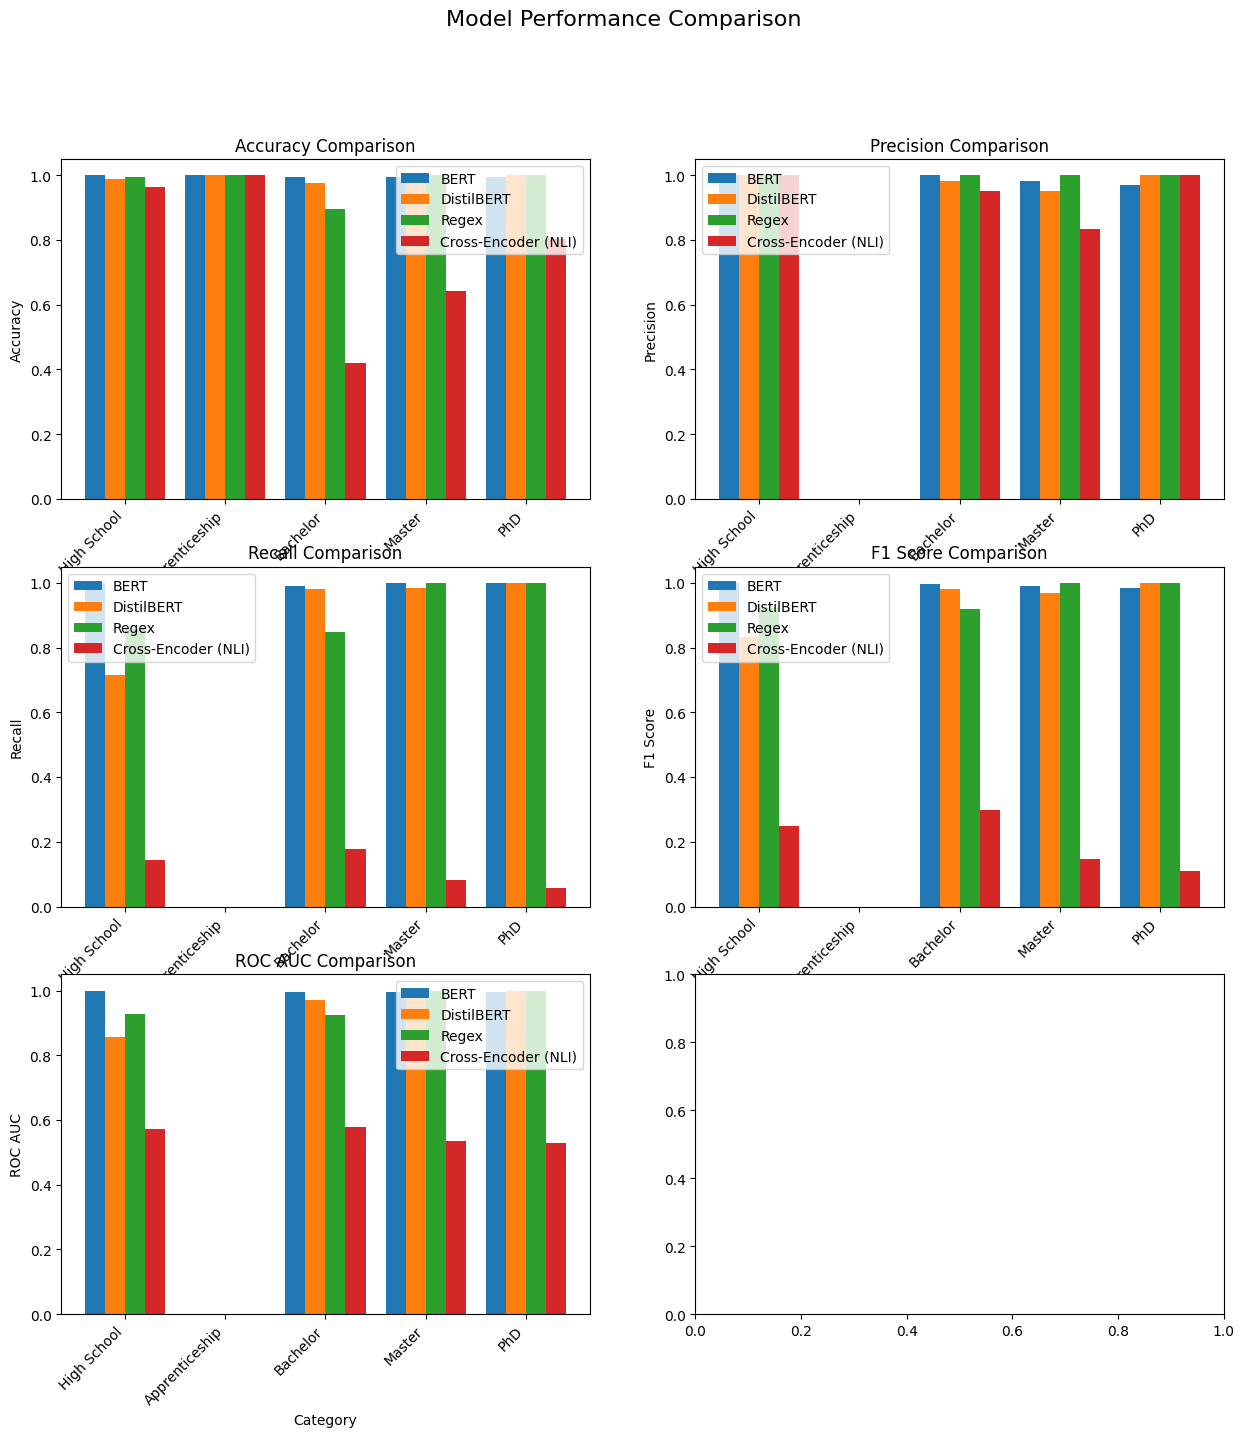

In [ ]:
import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from tqdm import tqdm


def get_nli_predictions(x: pd.DataFrame, model_name: str, device: str = "cuda") -> pd.DataFrame:
    """
    Get predictions from an NLI cross-encoder model.

    Args:
    x (pd.DataFrame): Input data containing texts.
    model_name (str): HuggingFace model name to use.
    device (str): Device to run the model on (default: 'cuda').

    Returns:
    pd.DataFrame: Binary predictions (0 or 1) for each degree level (High School, Apprenticeship, etc.).
    """
    # Load the model and tokenizer
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForSequenceClassification.from_pretrained(model_name)
    model.to(device)
    model.eval()  # Set the model to evaluation mode

    texts = x["text"].tolist()
    degree_levels = ["High School", "Apprenticeship", "Bachelor", "Master", "PhD"]  # Degrees to predict for

    predictions = []

    for text in tqdm(texts, desc="Processing texts"):
        text_predictions = []

        for degree in degree_levels:
            statement = f"{degree} is required"
            inputs = tokenizer(text, statement, return_tensors="pt", truncation=True, max_length=512, padding=True)
            inputs = {k: v.to(device) for k, v in inputs.items()}

            with torch.no_grad():
                outputs = model(**inputs)
                logits = outputs.logits

                probabilities = torch.softmax(logits, dim=1)
                # NLI task: 1 if entailment, 0 contradiction, 2 neutral
                prediction = 1 if (probabilities.argmax(dim=1).item() == 1) else 0  # Class 1 is "entailment"

                text_predictions.append(prediction)

        predictions.append(text_predictions)

    # Convert predictions to a DataFrame with degree level columns
    pred_df = pd.DataFrame(predictions, columns=degree_levels)

    return pred_df


# Example Usage:
# For NLI task (e.g., contradiction/entailment/neutral classification)
y_pred_nli = get_nli_predictions(
    x=x_test,
    model_name="cross-encoder/nli-deberta-v3-small",  # Using the NLI model
    device="cuda",
)

# Evaluate the NLI cross-encoder model
metrics_nli = evaluate_model(y_test, y_pred_nli)

print("NLI Model Performance:")
print(metrics_nli)

# Update the plot_comparison function call to include the NLI model
plot_comparison(
    metrics_bert,
    metrics_distilbert,
    metrics_regex,
    metrics_nli,
    model_names=["BERT", "DistilBERT", "Regex", "Cross-Encoder (NLI)"],
)

# LLMs

In [ ]:
!pip install unsloth

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 155.4/155.4 kB 14.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.3/474.3 kB 32.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.5/322.5 kB 25.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.4/209.4 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 318.4/318.4 kB 21.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.9/105.9 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.7/16.7 MB 49.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 55.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 16.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
from unsloth import FastLanguageModel
import torch
import pandas as pd
from transformers import TextStreamer

# Load the pre-trained Unsloth model (quantized for efficient memory usage)
max_seq_length = 2048
dtype = None  # Auto detection of dtype
load_in_4bit = True

model, tokenizer = FastLanguageModel.from_pretrained(
    model_name="unsloth/Phi-3.5-mini-instruct",  # Or any other model you prefer
    max_seq_length=max_seq_length,
    dtype=dtype,
    load_in_4bit=load_in_4bit,
)

# Enable fast inference mode
FastLanguageModel.for_inference(model)

# Define the labels
labels = ["High School", "Apprenticeship", "Bachelor", "Master", "PhD"]


# Function to create the classification prompt
def create_prompt(text):
    return f"Classify the following job description into education levels (High School, Apprenticeship, Bachelor, Master, PhD):\n\n{text}"


# Function to process the LLM output and convert it to a binary vector for multi-label classification
def process_llm_output(output_text):
    result_vector = [0] * len(labels)
    for idx, label in enumerate(labels):
        if label.lower() in output_text.lower():
            result_vector[idx] = 1
    return result_vector


# Function to classify all rows in the DataFrame
def multi_label_classification(df):
    y_pred = []
    for text in df["text"]:
        # Generate the classification prompt for each text entry
        prompt = create_prompt(text)

        # Prepare the input for the model
        messages = [{"from": "human", "value": prompt}]
        inputs = tokenizer.apply_chat_template(
            messages, tokenize=True, add_generation_prompt=True, return_tensors="pt"
        ).to("cuda")  # Use GPU if available

        # Perform the text generation (classification) using the model
        outputs = model.generate(input_ids=inputs, max_new_tokens=64, use_cache=True)
        output_text = tokenizer.batch_decode(outputs, skip_special_tokens=True)[0]

        # Process the output text to create a binary vector of classifications
        y_pred.append(process_llm_output(output_text))

    # Convert the predictions to a DataFrame with appropriate column names
    return pd.DataFrame(y_pred, columns=labels)


# Example usage with the `x` DataFrame
x = pd.DataFrame(
    {
        "text": [
            "Bachelor's degree or Master's degree in Computer Science",
            "Graduate degree in biostatistics or related field",
            "Currently has, or is in the process of obtaining, a Bachelor's degree",
            "MS in Machine Learning (PhD preferred)",
        ]
    }
)

# Run the multi-label classification and print the results
y_pred = multi_label_classification(x)
print(y_pred)

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.


AttributeError: module 'pyarrow.lib' has no attribute 'ListViewType'

# Next Steps
Some ideas for next steps
1. Manually review samples that have been misclassified. Maybe there is a problem with the labelled data.
2. Conduct a hyperparameter scan
3. Fine tune cross encoders
4. Fine tune a small LLM

